In [1]:
# Uncomment this if running on Paperspace VMs
# !cd /tmp
# !curl -sL https://deb.nodesource.com/setup_10.x | bash -
# !apt-get install -y nodejs
# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !pip install pandas

In [2]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils import data
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR, MultiStepLR
import utils

In [3]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_deep-learning-computation/use-gpu.html#computing-devices
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [4]:
!nvidia-smi

Thu Apr  7 11:35:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Building Model

In [5]:
class MLP(nn.Module):
    '''Multi Layer Perceptron'''
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.hidden = nn.Linear(in_dim, hidden_dim)  # Hidden layer
        self.out = nn.Linear(hidden_dim, out_dim)  # Output layer

    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

In [6]:
class Stem(nn.Module):
    '''Stem module which takes an H*W image and
       create patches of k*k and vectorize them
       with a dimension d
    '''
    def __init__(self, patch_size, hidden_dim, output_dim):
        super().__init__()
        self.kh, self.kw = patch_size, patch_size  # patch dimensions
        if 28 % patch_size == 0:
          self.kc = 28/patch_size
        else:
          raise Exception('Invalid patch size: Patch should be divisible by image width/height')
        self.dh, self.dw = patch_size, patch_size  # stride
        self.mlp = MLP(self.kw*self.kh, hidden_dim, output_dim)

    def forward(self, X):
        patches = X.unfold(2, self.kh, self.dh).unfold(3, self.kw, self.dw)
        patches = torch.flatten(patches, start_dim=4)
        patches = patches.reshape(patches.shape[0], 1, -1, self.kw * self.dw)
        out = self.mlp(patches)
        return out

In [7]:
class BackboneBlock(nn.Module):
    '''Backbone block with two MLPs'''
    def __init__(self, in_dim_1, hidden_dim_1, out_dim_1, in_dim_2, hidden_dim_2, out_dim_2):
        super().__init__()
        self.mlp1 = MLP(in_dim_1, hidden_dim_1, out_dim_1)
        self.mlp2 = MLP(in_dim_2, hidden_dim_2, out_dim_2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        out = torch.transpose(X, 2, 3)
        out = self.mlp1(out)
        out = torch.transpose(out, 2, 3)
        return self.mlp2(self.dropout(out))

In [8]:
class Classifier(nn.Module):
    '''Classifier takes input matrix and 
       produce a vector of output dimension'''
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, X):
        mean = X.mean(axis=2).reshape(X.shape[0], -1)
        return self.linear(mean)

In [9]:
def kaiming(m):
  """Initialize the weights with Kaimen method"""
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight, mode='fan_in')

In [10]:
def xavier(m):
    """Initialize the weights with Xavier method"""
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [11]:
patch_size = 4
# Check if patch size is valid
assert 28 % patch_size == 0 
no_of_patches = int((28/patch_size)**2)
# Create the model with blocks
net = nn.Sequential(
    Stem(patch_size, 64, 128),                               # Stem

    BackboneBlock(no_of_patches, 256, 128, 128, 256, 128),   # =================
    nn.Dropout(p=0.4),                                       # Backbone
    BackboneBlock(128, 256, no_of_patches, 128, 256, 128),   # 
    nn.Dropout(p=0.3),                                       # =================

    Classifier(128, 10))                                     # Classifier

# Move model to GPU if GPU is available
net = net.to(device=try_gpu())
# Initialise weights
net.apply(kaiming)

Sequential(
  (0): Stem(
    (mlp): MLP(
      (hidden): Linear(in_features=16, out_features=64, bias=True)
      (out): Linear(in_features=64, out_features=128, bias=True)
    )
  )
  (1): BackboneBlock(
    (mlp1): MLP(
      (hidden): Linear(in_features=49, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=128, bias=True)
    )
    (mlp2): MLP(
      (hidden): Linear(in_features=128, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (2): Dropout(p=0.4, inplace=False)
  (3): BackboneBlock(
    (mlp1): MLP(
      (hidden): Linear(in_features=128, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=49, bias=True)
    )
    (mlp2): MLP(
      (hidden): Linear(in_features=128, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (4): D

# Loading Data

In [12]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/image-classification-dataset.html#putting-all-things-together
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2, pin_memory=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2, pin_memory=True))

# Training and evaluating model

In [13]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [15]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(try_gpu())
            y = y.to(try_gpu())
            y_hat = net(X)
            metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

In [16]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#training
def train_epoch(net, train_iter, loss, updater):
    """The training loop for each epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X = X.to(try_gpu())
        y = y.to(try_gpu())
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#training

from IPython import display

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        utils.use_svg_display()
        self.fig, self.axes = utils.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: utils.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
# Source: d2l book
# Retrieved from https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#training
def train(net, train_iter, test_iter, loss, num_epochs, updater, scheduler):
    """Train a model"""
    accuracy_animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1],
                        legend=['train acc', 'test acc'], figsize=(10, 6))
    loss_animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 0.01],
                        legend=['train loss'], figsize=(10, 6))
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        if scheduler and updater.param_groups[0]['lr'] >= 1e-3:
            scheduler.step()
        accuracy_animator.add(epoch + 1, (train_metrics[1],) + (test_acc,))
        loss_animator.add(epoch + 1, (train_metrics[0],))
    train_loss, train_acc = train_metrics

In [19]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size)

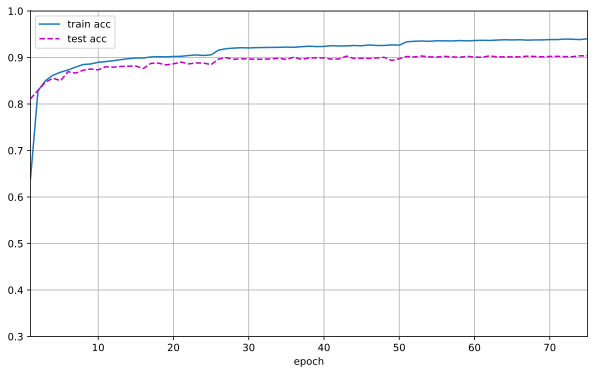

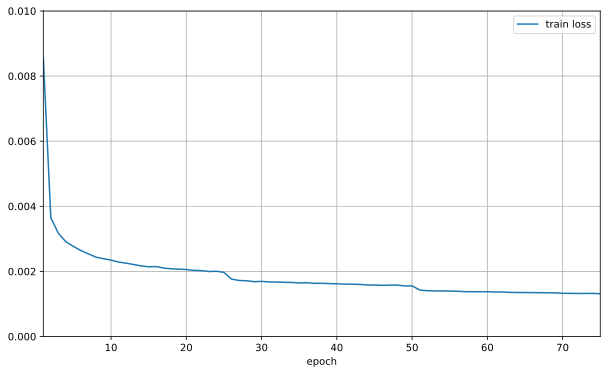

In [20]:
# Set the loss as Cross Entropy Loss
loss = nn.CrossEntropyLoss()
# Initialise SGD Optimizer with momentum
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# Reduce the learning rate by 30% after 25th and 50th epochs
scheduler = MultiStepLR(optimizer, milestones=[25, 50], gamma=0.3)
num_epochs = 75
train(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler)

# Validation Accuracy

In [21]:
# Display the accuracy on validation data
test_acc = evaluate_accuracy(net, test_iter)
test_acc

0.9036